<a href="https://colab.research.google.com/github/paulandrea0/AutoEncoder-Representacion-Se-ales/blob/main/13_06_22AutoEncoder__sinais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Conectarme a Drive para cargar los set de entrenamiento y validación**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%reset
df_test = pd.read_csv('/gdrive/MyDrive/Sismos/VT_Z_teste.csv')
df_train = pd.read_csv('/gdrive/MyDrive/Sismos/VT_Z_train.csv') 


**Aplicando una función Mean en el DataFrame original para quitar el offset de los datos**

(1480, 13348)
(256, 10993)


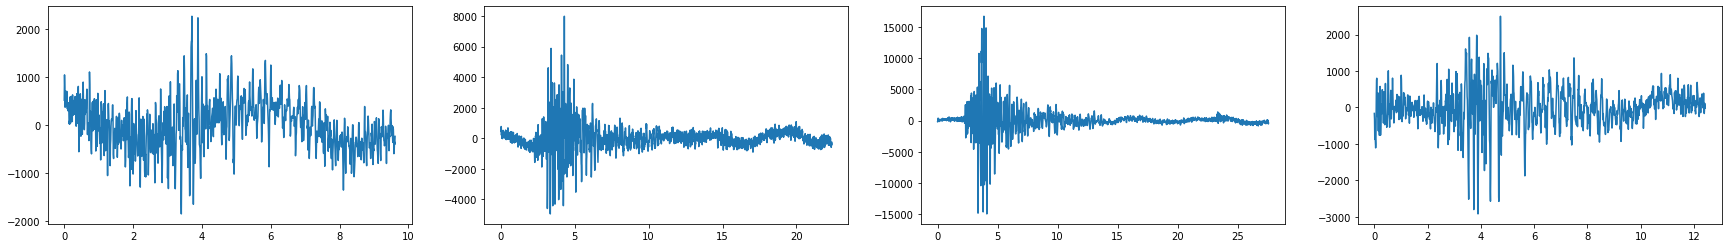

In [ ]:
# Creando función para retirar el offset de los datos en DataFrame
def mean_norma(df_input):
        return df_input.apply(lambda x: (x-x.mean()), axis=1)  

df_mean_test = mean_norma(df_test)
df_mean_train = mean_norma(df_train)

print(df_mean_train.shape)
print(df_mean_test.shape)

# Convirtiendo el dataframe en array
d_train = df_mean_train.values
d_train = d_train[:, 0:6000]
d_test = df_mean_test.values
d_test = d_test[:, 0:6000]

# Dibujando la señal orioginal
#n = 3000
n = 6000
fs = 50 # frecuencia de muestreo
t = np.linspace(0,fs,n)
plt.figure(1, figsize=(30, 4))
plt.title("señal original")
plt.subplot(141)
plt.plot(t, d_train[60])
plt.subplot(142)
plt.plot(t, d_train[18])
plt.subplot(143) 
plt.plot(t, d_train[38])
plt.subplot(144)
plt.plot(t, d_train[54])

**Aplicando la transformada de Fourier**

(1480, 6000)
(256, 6000)
3000
(1480, 6000)
(256, 6000)
(1480, 3000)
(256, 3000)


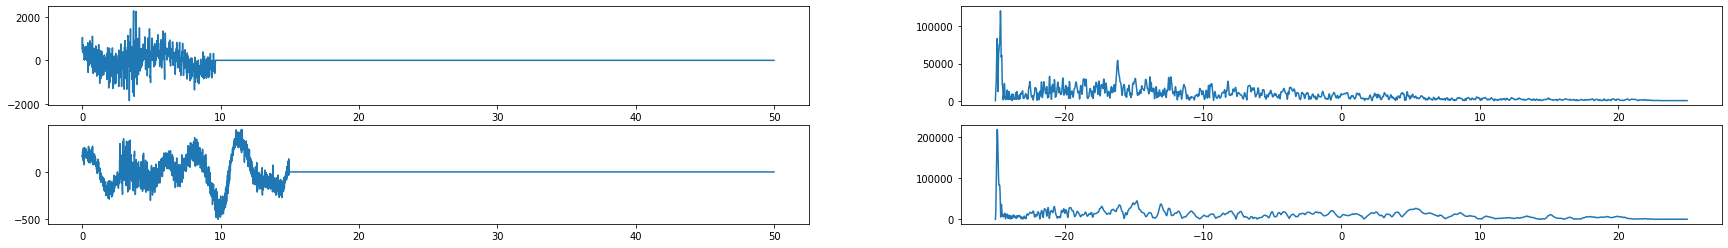

In [ ]:
import scipy.fft as sfft

# Quitando los valores NaN de los array numpy
d_train[np.isnan(d_train)] = 0.0
d_test[np.isnan(d_test)] = 0.0
print(d_train.shape)
print(d_test.shape)

# Transformada de Fourier
n2 = 3000
#n2 = 2048
t2 = np.linspace(0,fs,n2) # creando un vector de tiempo
#t = np.arange(0, 5, step=1./fs)  # creando un vector de tiempo (start, stop, step)
print(len(t2))

f = sfft.fftshift(sfft.fftfreq(n=len(t2), d=1./fs))
S_train = sfft.fftshift(sfft.fft(d_train))
SA_train = np.absolute(S_train)
SA_train = SA_train[:, 3000:6000]
SP_train = np.angle(S_train)

S_test = sfft.fftshift(sfft.fft(d_test))
SA_test = np.absolute(S_test)
SA_test = SA_test[:, 3000:6000]
SP_test = np.angle(S_test)

print(d_train.shape)
print(d_test.shape)
print(SA_train.shape)
print(SA_test.shape)

# Graficando
plt.figure(2, figsize=(30, 4))
plt.title("Aplicando Transformada de Fourier")
plt.subplot(221)
plt.plot(t, d_train[60])
plt.subplot(222)
plt.plot(f, SA_train[60])
plt.subplot(223)
plt.plot(t, d_test[3])
plt.subplot(224)
plt.plot(f, SA_test[3])

**Preprocesamiento (reajuste y normalización)**

Mínimo y máximo originales: -2710525.5, 2436521.9
Mínimo y máximo normalizado: 0.0, 1.0


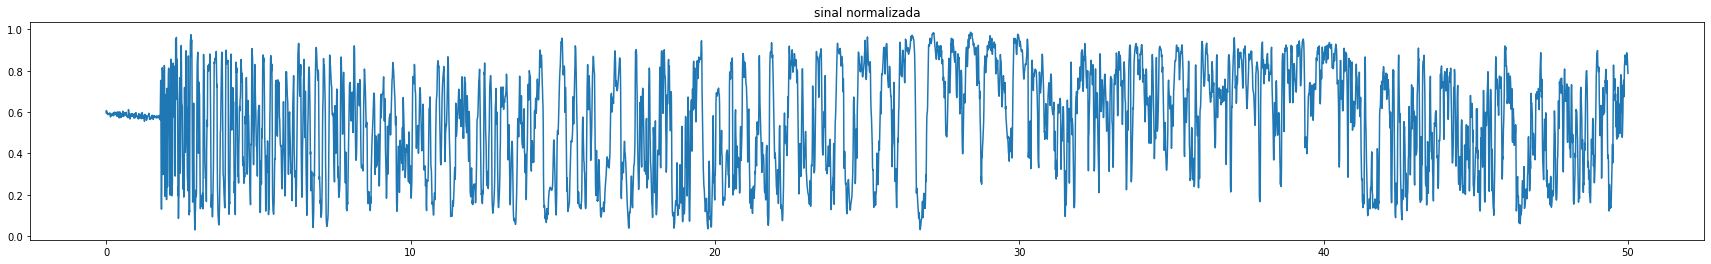

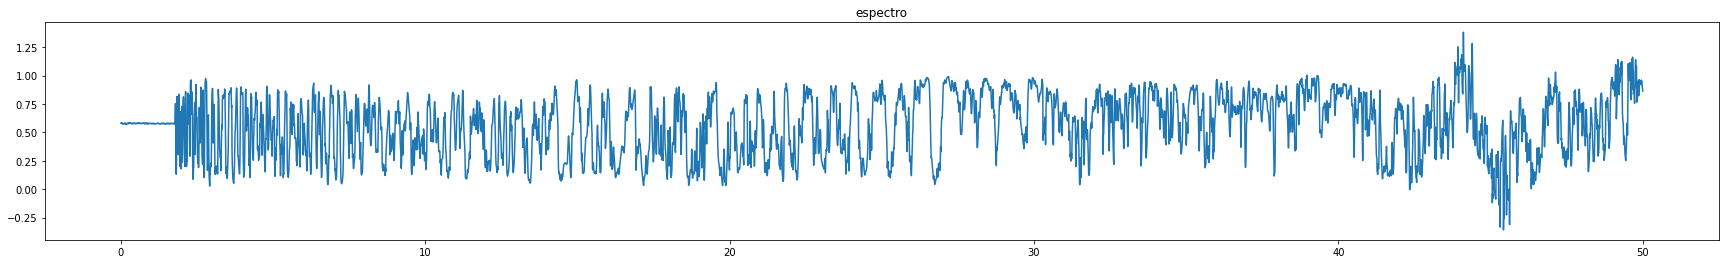

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
D_train_s = min_max_scaler.fit_transform(d_train)
#SA_train_s = min_max_scaler.fit_transform(SA_train)
print('Mínimo y máximo originales: {:.1f}, {:.1f}'.format(np.min(d_train), np.max(d_train)))      # OJO  aqui se requiere verificar si se estra trabajando en el dominio del tiempo o de frecuencia
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}'.format(np.min(D_train_s), np.max(D_train_s))) # OJO  aqui se requiere verificar si se estra trabajando en el dominio del tiempo o de frecuencia

D_test_s = min_max_scaler.transform(d_test)   # OJO  aqui se requiere verificar si se estra trabajando en el dominio del tiempo o de frecuencia


# Graficando
plt.figure(3, figsize = (30, 4))
plt.title("sinal normalizada")
plt.plot(t, D_train_s[60])

plt.figure(4, figsize = (30, 4))
plt.title("espectro")
plt.plot(t, D_test_s[60])

# AutoEncoder en TensorFlow/Keras

**Importar TesorFlow 2 (ya incluye Keras)**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print('version de TensorFlow:' + tf.__version__)

version de TensorFlow:2.8.2


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras import Sequential
from keras.regularizers import l2 # cuando hay sobreajuste la regularización ayuda
# a decartar valores altos en la función de costo. Se puede colocar en cualquier capa
from keras.layers import Dropout  #apagar aleatoriamente algunas neuronas, 
# ayudando a eliminar el sobreajuste
from keras.callbacks import EarlyStopping
np.random.seed(23)

dim_entrada = D_train_s.shape[1]   # OJO  aqui se requiere verificar si se estra trabajando en el dominio del tiempo o de frecuencia   
entrada = Input(shape=(dim_entrada,))
print(D_train_s.shape[1])          # OJO  aqui se requiere verificar si se estra trabajando en el dominio del tiempo o de frecuencia   

# Encoder
x = Dense(3000, activation='relu', kernel_regularizer=l2(0.005))(entrada)
x = Dropout(0.25)(x)
x = Dense(1500, activation='relu', kernel_regularizer=l2(0.005))(x)
x = Dropout(0.25)(x)
x = Dense(600, activation='relu', kernel_regularizer=l2(0.005))(x)
x = Dropout(0.25)(x)
x = Dense(400, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(200, activation='relu')(x)
x = Dropout(0.25)(x)
encoded = Dense(50, activation='relu', name='bottleneck_layer')(x)


# Decoder 
x = Dense(100, activation='relu')(encoded)
x = Dense(200, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(600, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(1500, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(3000, activation='relu')(x)
x = Dropout(0.25)(x)
decoded = Dense(6000, activation='sigmoid')(x)


# autoencoder = entrada + decoder (que contiene el encoder)
autoencoder = Model(inputs=entrada, outputs=decoded)

autoencoder.summary()

6000
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6000)]            0         
                                                                 
 dense_24 (Dense)            (None, 3000)              18003000  
                                                                 
 dropout_20 (Dropout)        (None, 3000)              0         
                                                                 
 dense_25 (Dense)            (None, 1500)              4501500   
                                                                 
 dropout_21 (Dropout)        (None, 1500)              0         
                                                                 
 dense_26 (Dense)            (None, 600)               900600    
                                                                 
 dropout_22 (Dropout)        (None, 600)             

# Optimización y Entrenamiento

La pérdida corresponderá al error absoluto medio(Mean Absolute Error, MAE.
El optimizador será adam

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
historia = autoencoder.fit(D_train_s, D_train_s,    # OJO  aqui se requiere verificar si se estra trabajando en el dominio del tiempo o de frecuencia
                           epochs=20,
                           batch_size=150,
                           validation_data=(D_test_s, D_test_s),    # OJO  aqui se requiere verificar si se estra trabajando en el dominio del tiempo o de frecuencia
                           shuffle=True)

Epoch 1/20
10/10 [==============================] - 12s 1s/step - loss: 22.6503 - accuracy: 0.0000e+00 - val_loss: 11.4851 - val_accuracy: 0.0000e+00
Epoch 2/20
10/10 [==============================] - 10s 998ms/step - loss: 6.9690 - accuracy: 0.0196 - val_loss: 3.1954 - val_accuracy: 0.0000e+00
Epoch 3/20
10/10 [==============================] - 10s 1s/step - loss: 2.0003 - accuracy: 0.0534 - val_loss: 1.1218 - val_accuracy: 0.0000e+00
Epoch 4/20
10/10 [==============================] - 10s 997ms/step - loss: 0.7714 - accuracy: 0.0973 - val_loss: 0.5239 - val_accuracy: 0.0039
Epoch 5/20
10/10 [==============================] - 10s 1s/step - loss: 0.3454 - accuracy: 0.1541 - val_loss: 0.2221 - val_accuracy: 0.9023
Epoch 6/20
10/10 [==============================] - 10s 997ms/step - loss: 0.1390 - accuracy: 0.2088 - val_loss: 0.1033 - val_accuracy: 0.9023
Epoch 7/20
10/10 [==============================] - 10s 993ms/step - loss: 0.0583 - accuracy: 0.2709 - val_loss: 0.0561 - val_accurac

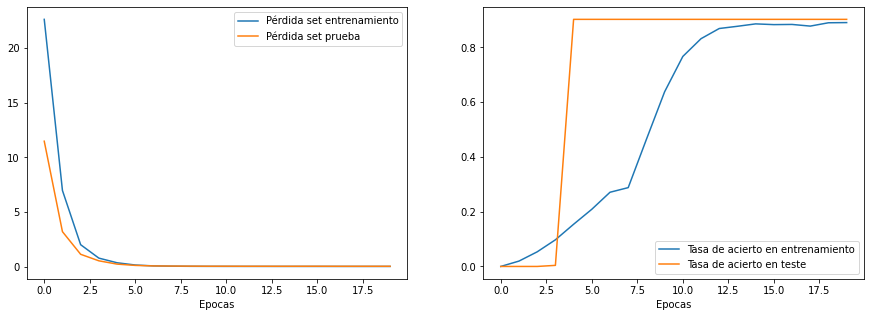

In [ ]:
import matplotlib.pyplot as plt
plt.figure(5, figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(historia.history["loss"], label="Pérdida set entrenamiento")
plt.plot(historia.history["val_loss"], label="Pérdida set prueba")
plt.xlabel('Epocas')
plt.legend()
plt.subplot(1,2,2)
plt.plot(historia.history["accuracy"], label="Tasa de acierto en entrenamiento")
plt.plot(historia.history["val_accuracy"], label="Tasa de acierto en teste")
plt.xlabel('Epocas')
plt.legend()


**Caracterización (Bottleneck)**

In [ ]:
encoder = Model(entrada, encoded)
espacio_latente = encoder.predict(D_train_s)

(1480, 50)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f97ae31bfd0>,
 [<matplotlib.lines.Line2D at 0x7f97add138d0>])

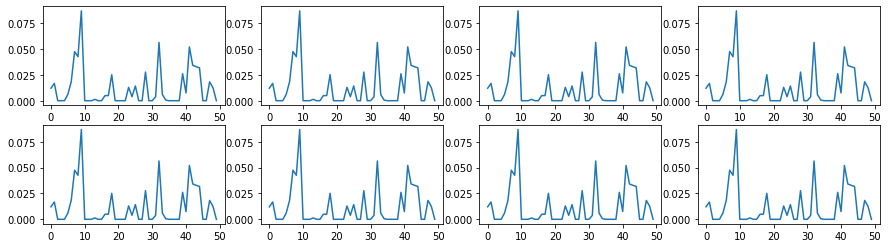

In [ ]:
espacio_latente
print(espacio_latente.shape)
plt.figure(6, figsize=(15, 4))
plt.title("Representación")
plt.subplot(241), plt.plot(espacio_latente[60])
plt.subplot(242), plt.plot(espacio_latente[18])
plt.subplot(243), plt.plot(espacio_latente[38])
plt.subplot(244), plt.plot(espacio_latente[54])
plt.subplot(245), plt.plot(espacio_latente[106])
plt.subplot(246), plt.plot(espacio_latente[128])
plt.subplot(247), plt.plot(espacio_latente[141])
plt.subplot(248), plt.plot(espacio_latente[160])

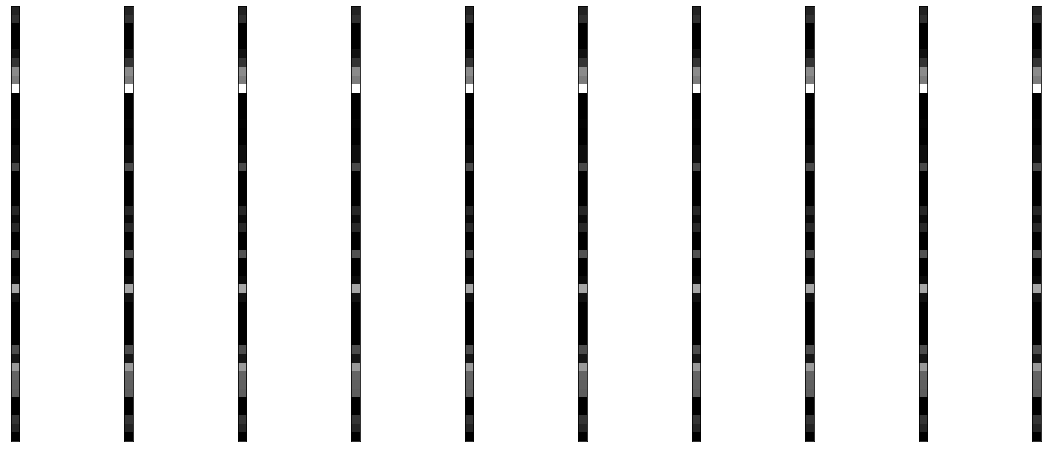

In [ ]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(espacio_latente[i].reshape((espacio_latente.shape[1],1)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Calculando as representações

(256, 50)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f97b6848190>,
 [<matplotlib.lines.Line2D at 0x7f97b3ac6490>])

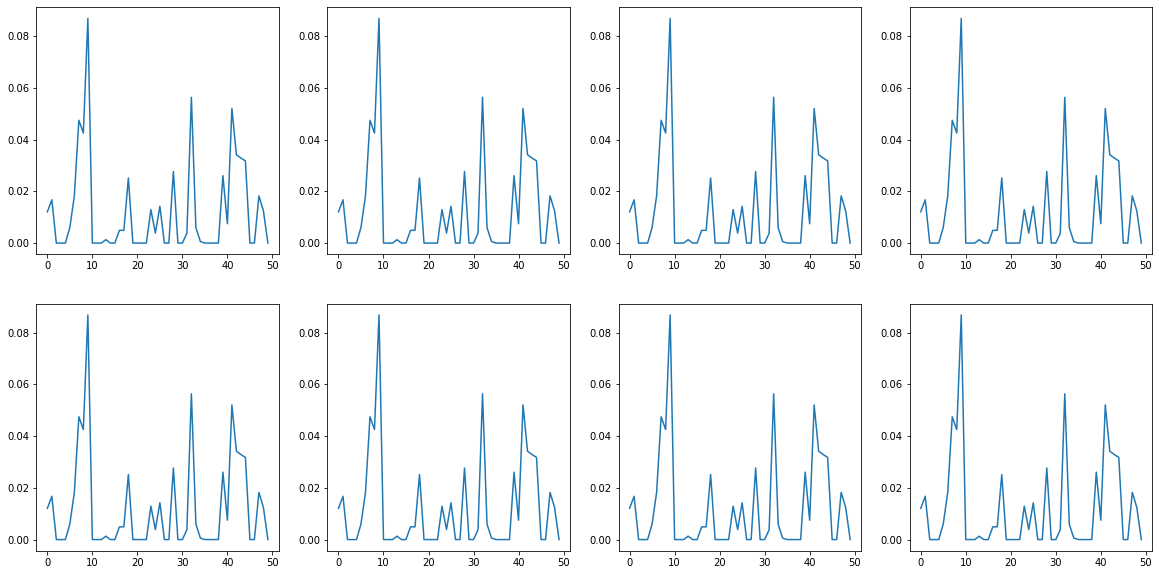

In [ ]:
coder = Model(inputs=entrada, outputs=encoded)
encoder = Model(entrada, encoded)
rep = coder(D_test_s)

print(rep.shape)
plt.figure(7, figsize=(20, 10))
plt.title("Representación")
plt.subplot(241), plt.plot(rep[60])
plt.subplot(242), plt.plot(rep[18])
plt.subplot(243), plt.plot(rep[38])
plt.subplot(244), plt.plot(rep[54])
plt.subplot(245), plt.plot(rep[106])
plt.subplot(246), plt.plot(rep[128])
plt.subplot(247), plt.plot(rep[141])
plt.subplot(248), plt.plot(rep[160])
#pd.DataFrame(espacio_latente).to_csv('rep_LPe.csv', index = None)


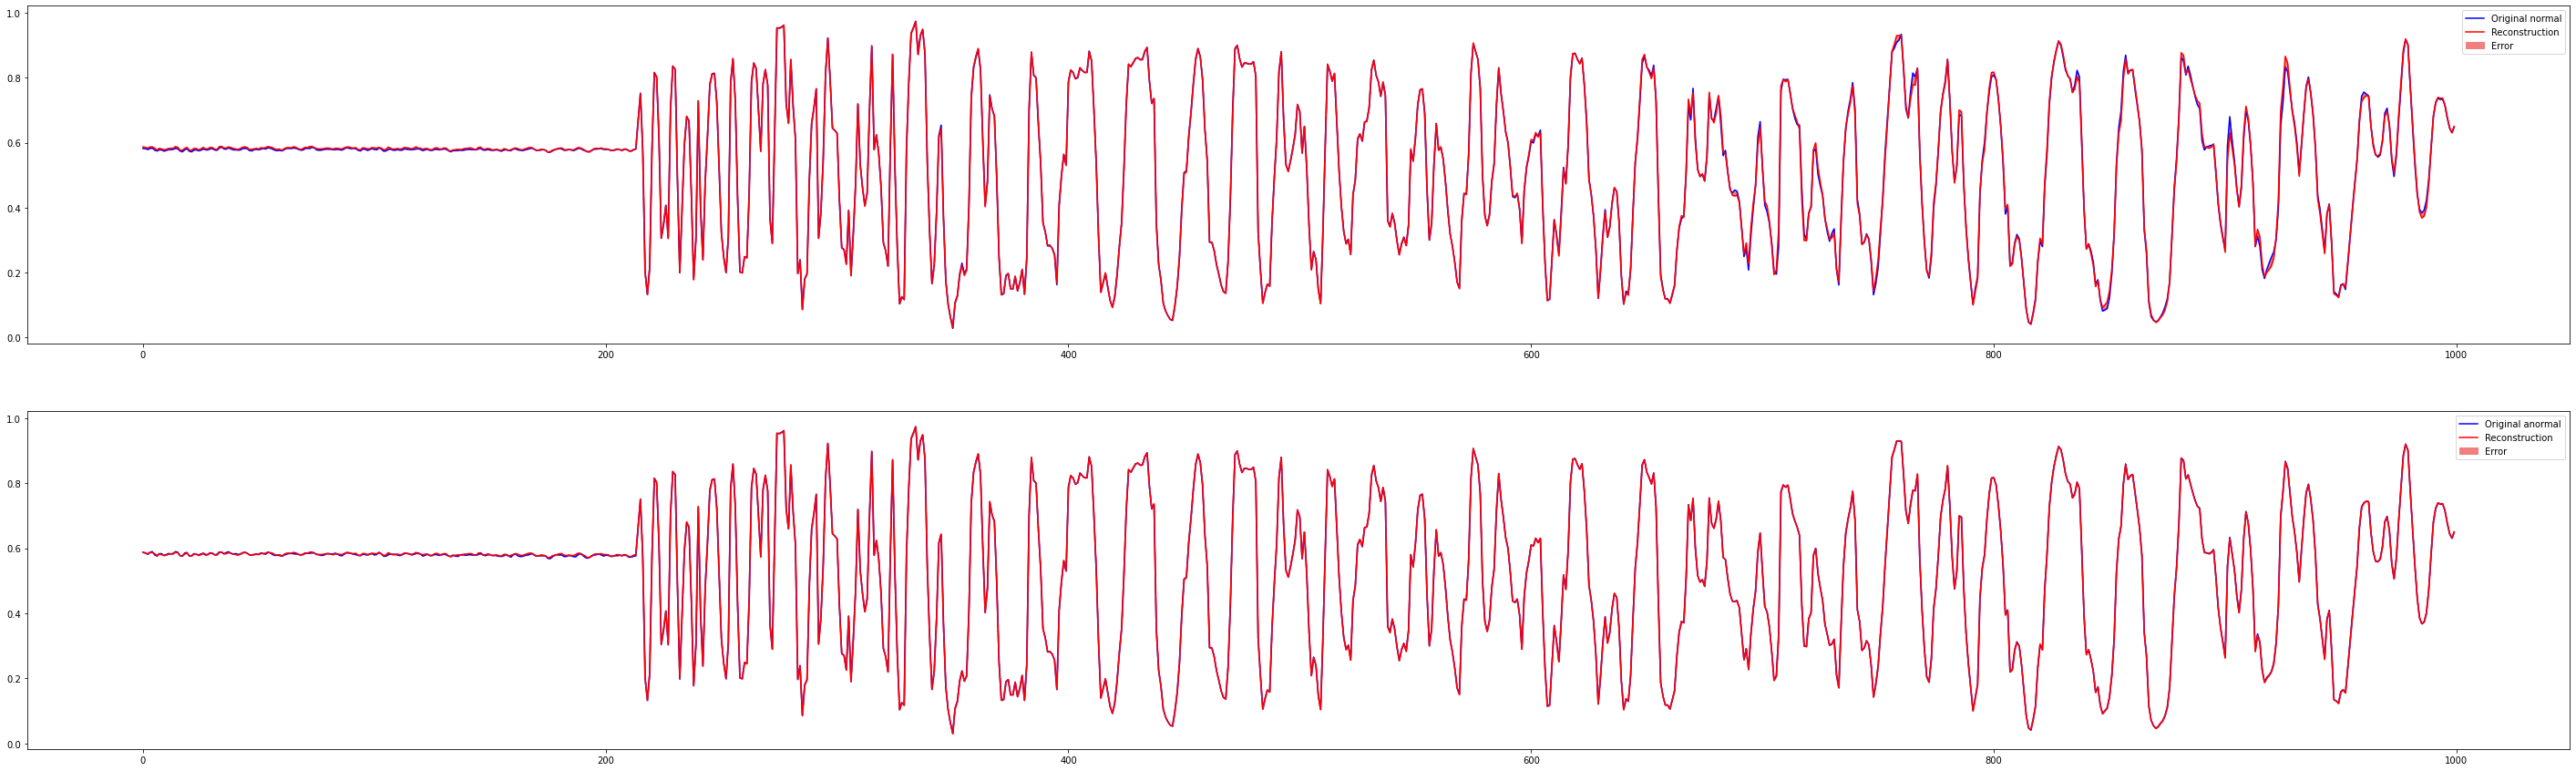

In [ ]:
rec_normal = autoencoder(D_test_s).numpy()
rec_normal = rec_normal[:, 0:1000]
D_test_s = D_test_s[:, 0:1000]
plt.figure(figsize=(50,15))
plt.subplot(2,1,1)
plt.plot(D_test_s[60],'b')
plt.plot(rec_normal[60],'r')
plt.fill_between(np.arange(1000), rec_normal[60], D_test_s[60], color='lightcoral')
plt.legend(labels=["Original normal", "Reconstruction", "Error"])
plt.subplot(2,1,2)
plt.plot(D_test_s[18],'b')
plt.plot(rec_normal[18],'r')
plt.fill_between(np.arange(1000), rec_normal[18], D_test_s[18], color='lightcoral')
plt.legend(labels=["Original anormal", "Reconstruction", "Error"])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f97ae53fb10>,
 [<matplotlib.lines.Line2D at 0x7f97afdcac10>])

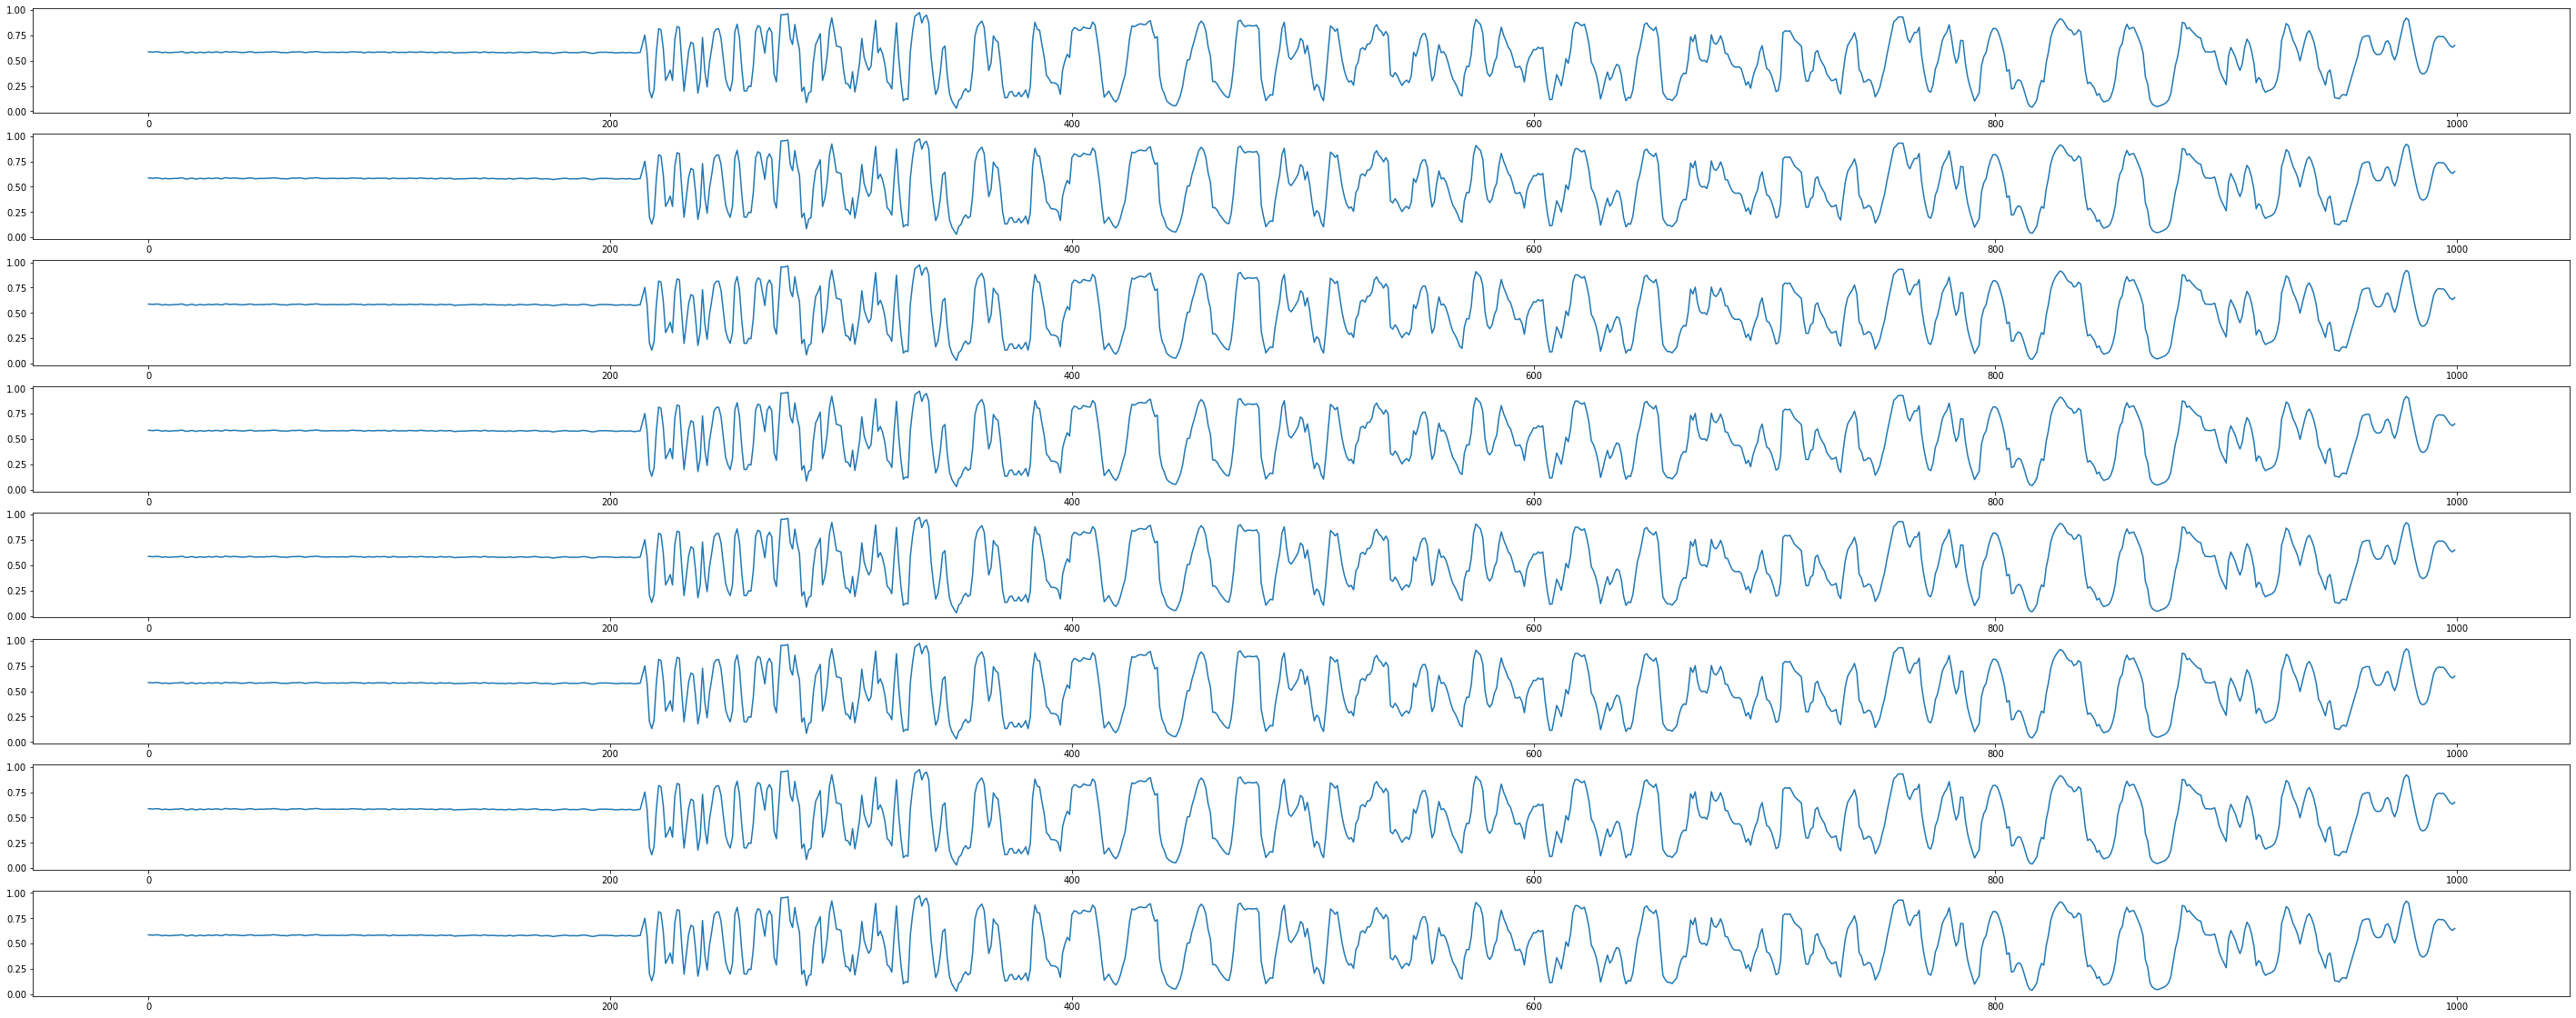

In [ ]:
plt.figure(7, figsize=(50, 20))
plt.subplot(811), plt.plot(rec_normal[60])
plt.subplot(812), plt.plot(rec_normal[18])
plt.subplot(813), plt.plot(rec_normal[38])
plt.subplot(814), plt.plot(rec_normal[54])
plt.subplot(815), plt.plot(rec_normal[106])
plt.subplot(816), plt.plot(rec_normal[128])
plt.subplot(817), plt.plot(rec_normal[141])
plt.subplot(818), plt.plot(rec_normal[160])